# Microsoft Movie Studios Analysis

**Authors:** Dan Tong  
**Student Pace:** FLEX  
**Scheduled Project Review Date/Time:**  
**Instructor Name:** Claude Fried  
**Blog Post URL:**
***
<img src='./images/movie.png' alt='Top Grossing Movie Posters' style='border:10px solid black'>

## Overview
Using data from The Numbers and IMDB, this project aims to analyze the most successful films for Microsoft's new movie studio. This project seeks to define "success" by examining ratings, popular genres, film lengths, seasonality of movie releases. The findings of this project may help Microsoft approach the ever-expanding film industry.

## Business Problem

Microsoft may be able to find the most financial and critical success through this analysis. By examining film genres, I can identify success by average ratings and average return on investment. I also look into release dates to try to determine the best time to release certain films and any other potential trends.

***

## Data Understanding

IMDB and The numbers are two of the largest databases for publicly sourced movie data. IMDB contains general information, such as genre, release date, cast and crew, on millions of titles. IMDB also has over 80 million registered users contributing their opinions on films via ratings and reviews. The Numbers is a database that tracks box office revenues. 

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
imdb = sqlite3.connect('./zippedData/im.db')
tn_df = pd.read_csv('./zippedData/tn.movie_budgets.csv', index_col=0)

In [3]:
imdb_df = pd.read_sql("""
                SELECT original_title, start_year, runtime_minutes, genres, averagerating, numvotes
                FROM movie_basics
                JOIN movie_ratings
                    USING(movie_id);
""", imdb)

### IMDB Data
<img src='./images/imdb.png' alt='IMDB logo' width=200 height=200 align=left>
The IMDB dataset has records from films that were released between 2010 and 2019 and basic information like average rating, number of votes, cast, and crew.

In [4]:
imdb_df.head(3)

,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,The Other Side of the Wind,2018,122.0,Drama,6.9,4517


### The Numbers Data
<img src='./images/the_numbers_logo.svg' alt='The Numbers logo' width=300 height=300 align=left>
The Numbers dataset has information on a film's exat release date, production budget, and gross revenue.

In [5]:
tn_df.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


## Data Preparation
With these two datasets, I pulled data regarding:
* Budget and Revenues
* 

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### Data Cleaning
#### IMDB Data
For the IMDB dataset, the "start_year" column are integers but, for the purposes of my analysis, I need them to be strings so I can properly group the years.

In [6]:
imdb_df['start_year'] = imdb_df['start_year'].astype(str)

The "genres" column in the IMDB dataset contains lists of multiple genres for some films, so I split films with multiple genres into separate entries for each genre and updated my dataframe to reflect that.

In [7]:
g = imdb_df.genres.str.split(',', expand=True).stack()
g.index = g.index.droplevel(-1)
g.name = 'genres'
del imdb_df['genres']
imdb_df = imdb_df.join(g)

#### The Numbers Data
The Numbers data on budget and gross are entered as strings, so in order to work with the numbers I have to turn them into integers.

In [8]:
#converting worldwide_gross and production_budget columns to integers instead of strings
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace(',','').str.replace('$','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(np.int64)
tn_df['production_budget'] = tn_df['production_budget'].str.replace(',','').str.replace('$','')
tn_df['production_budget'] = tn_df['production_budget'].astype(np.int64)

In [9]:
tn_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875
3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350
4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747


To examine release dates more closely, I'm separating strings from the "release_date" column to create new columns for "release_year" and "release_month." I'm also creating a new column for the season in which the film is released, called "release_season."

In [10]:
tn_df['release_year'] = tn_df['release_date'].str[-4:]
tn_df['release_month'] = tn_df['release_date'].str[:3]

conditions = [
    (tn_df['release_month'].str.contains('Dec')),
    (tn_df['release_month'].str.contains('Jan')),
    (tn_df['release_month'].str.contains('Feb')),
    (tn_df['release_month'].str.contains('Mar')),
    (tn_df['release_month'].str.contains('Apr')),
    (tn_df['release_month'].str.contains('May')),
    (tn_df['release_month'].str.contains('Jun')),
    (tn_df['release_month'].str.contains('Jul')),
    (tn_df['release_month'].str.contains('Aug')),
    (tn_df['release_month'].str.contains('Sep')),
    (tn_df['release_month'].str.contains('Oct')),
    (tn_df['release_month'].str.contains('Nov'))
]

values = ['Winter','Winter','Winter','Spring','Spring','Spring','Summer','Summer','Summer','Fall','Fall','Fall']

tn_df['release_season'] = np.select(conditions, values)

### Merging The Numbers and IMDB datasets
The IMDB dataset doesn't contain financial information. By merging the two datasets, I will be able to analyze financial and ratings data with respect to genre and release month.

In [11]:
# Merging databases to use for films released since 2010 with data in both dataframes
movies_df = pd.merge(tn_df, imdb_df, left_on=['movie', 'release_year'], right_on=['original_title','start_year'])
movies_df = movies_df.drop(columns=['domestic_gross', 'release_date', 'start_year', 'original_title'])

#changing financials into Millions for easier visualizations
movies_df['production_budget'] = movies_df['production_budget']/1000000
movies_df['worldwide_gross'] = movies_df['worldwide_gross']/1000000

#creating a new column for Return on Investment to measure a film's financial success
movies_df['roi'] = ((movies_df['worldwide_gross'] - movies_df['production_budget'])/movies_df['production_budget']) * 100

In [12]:
movies_df.head(3)

,movie,production_budget,worldwide_gross,release_year,release_month,release_season,runtime_minutes,averagerating,numvotes,genres,roi
0,Pirates of the Caribbean: On Stranger Tides,410.6,1045.663875,2011,May,Spring,136.0,6.6,447624,Action,154.667286
1,Pirates of the Caribbean: On Stranger Tides,410.6,1045.663875,2011,May,Spring,136.0,6.6,447624,Adventure,154.667286
2,Pirates of the Caribbean: On Stranger Tides,410.6,1045.663875,2011,May,Spring,136.0,6.6,447624,Fantasy,154.667286


In [13]:
movies_df.describe()

,production_budget,worldwide_gross,runtime_minutes,averagerating,numvotes,roi
count,3796.000000,3796.000000,3785.000000,3796.000000,3.796000e+03,3796.000000
mean,48.539693,153.527597,108.394452,6.320100,1.219230e+05,275.682773
std,58.190240,241.306604,17.762439,1.038015,1.671651e+05,1268.461464
min,0.015000,0.000000,5.000000,1.600000,5.000000e+00,-100.000000
25%,10.000000,11.360665,95.000000,5.700000,1.847800e+04,-14.396524
50%,25.000000,61.031932,106.000000,6.400000,6.575400e+04,118.962353
75%,61.000000,173.613482,118.000000,7.100000,1.519262e+05,305.616742
max,410.600000,2048.134200,189.000000,8.800000,1.841066e+06,41556.474000


To examine how specific variables interact with one another, I created databases to make it easier to see possible relationships.

In [14]:
#Creating a database for average runtime for each average rating in the merged dataset
runtime_rating_df = movies_df[['runtime_minutes','averagerating']].groupby('averagerating').mean()

In [15]:
#I created a dataframe of runtime data grouped by genres in the merged dataset
genre_runtime_df = movies_df.groupby('genres').runtime_minutes.agg(['count','mean','median']).sort_values('count', ascending=False)

## Data Modeling
Describe and justify the process for analyzing or modeling the data.
I am

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [16]:
sns.set_theme(style='darkgrid')
sns.set_color_codes('pastel')

### Most Popular Genres
The IMDB dataset is larger than the merged dataset but Drama remains the most popular genre by far. Because of my methodology of separating films with multiple genres into individual entries, it's likely the most common overlapping genre. The top 10 remains largely the same. The main difference is with documentaries with the merged data having far fewer documentaries.

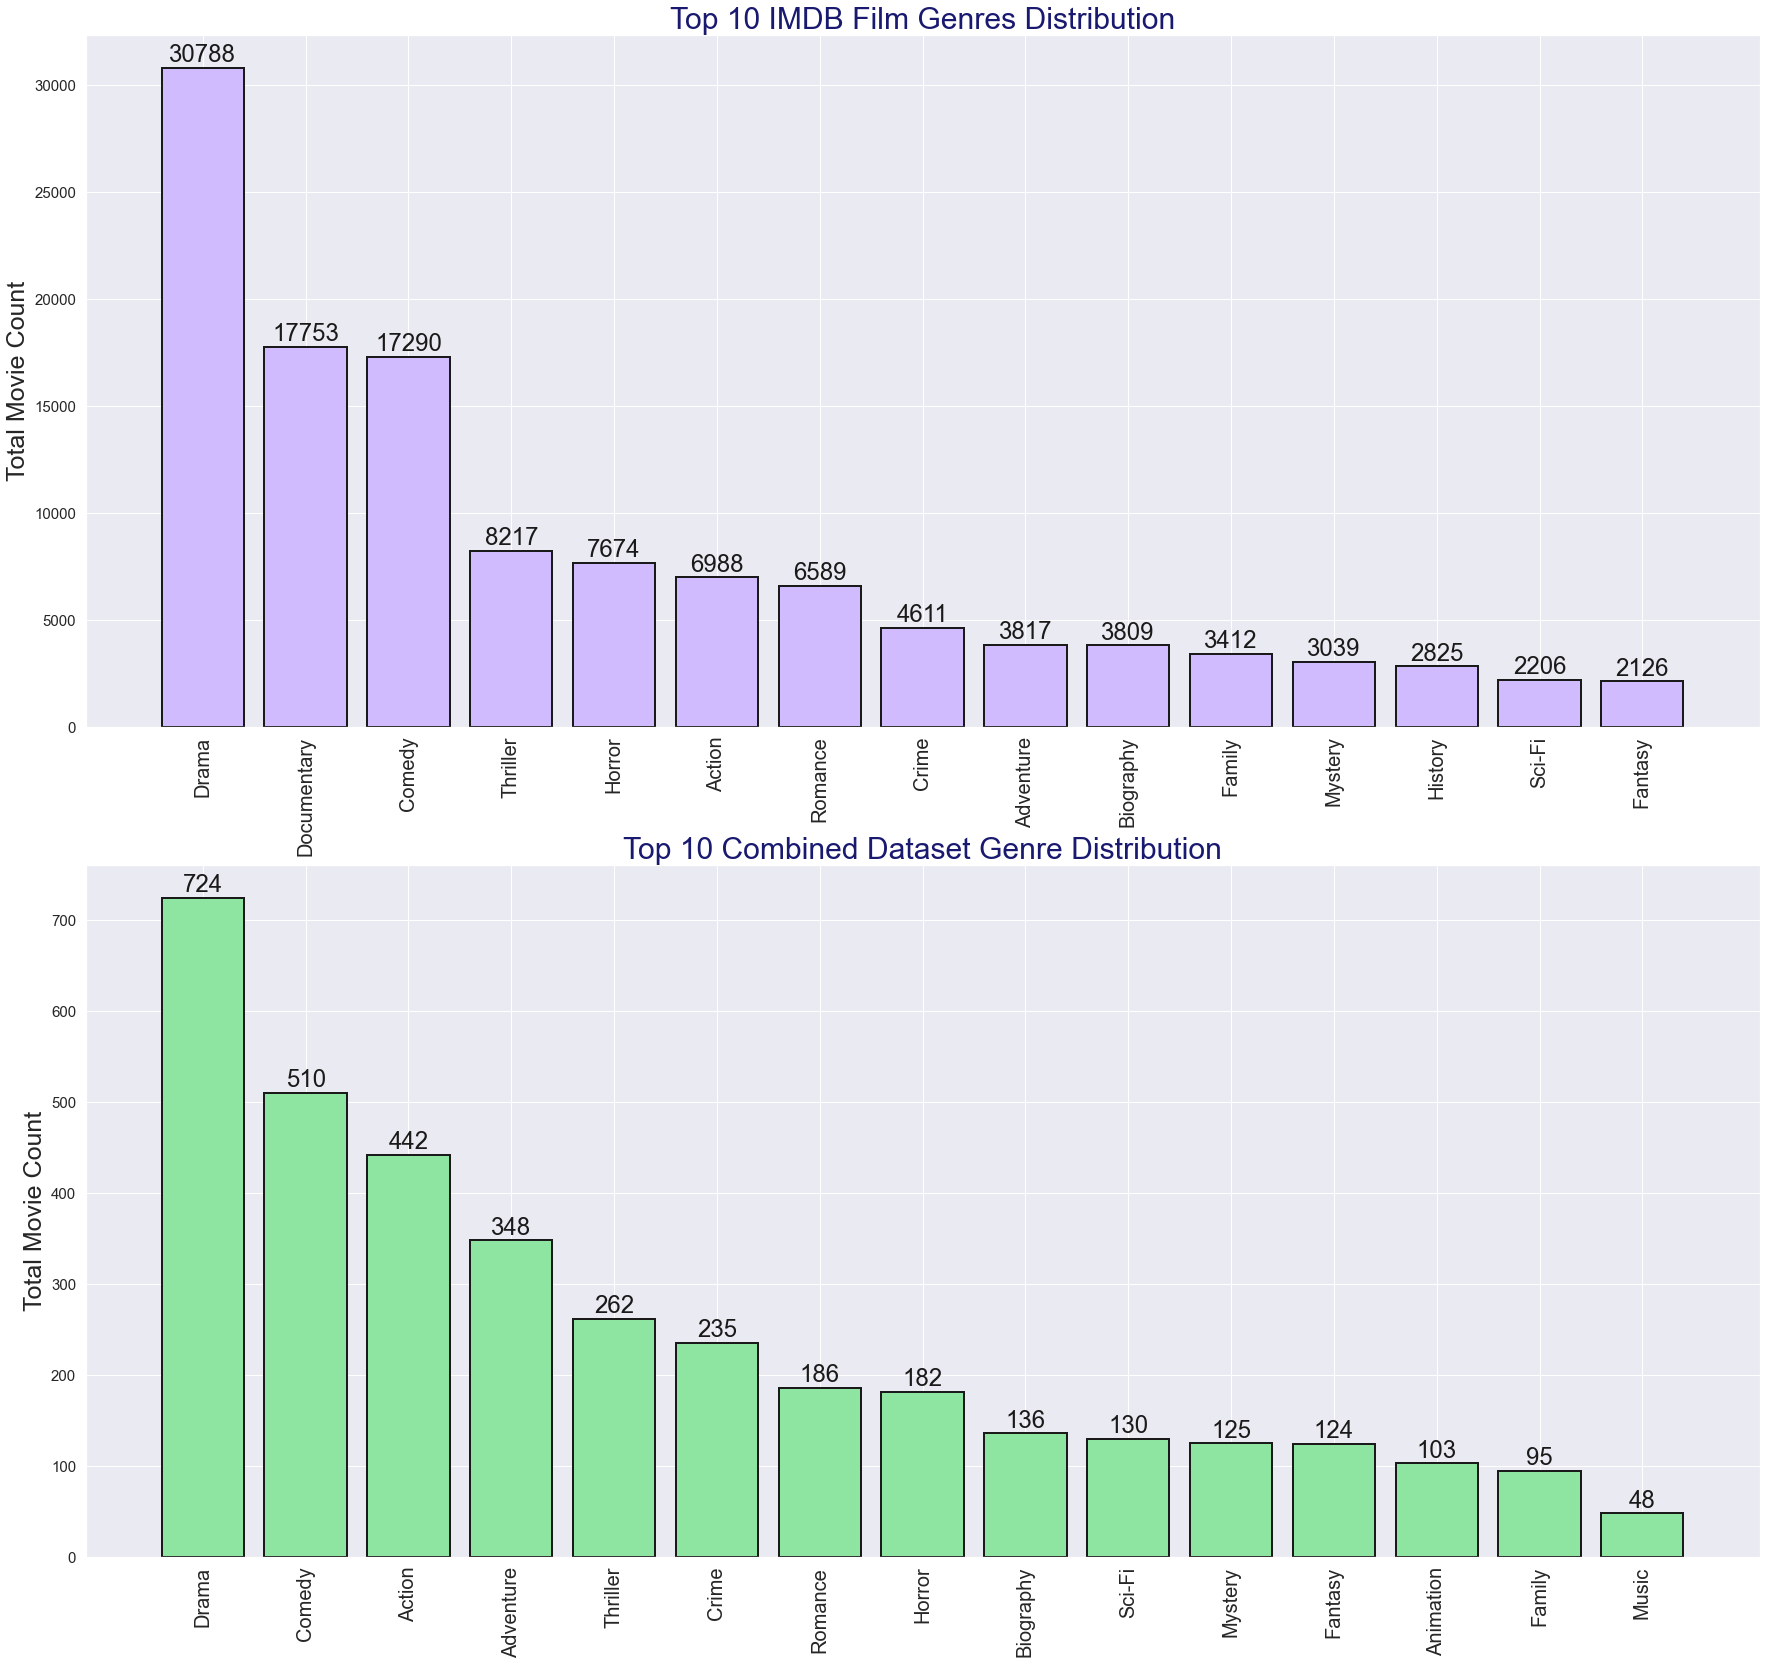

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30,28))

ax1.bar(
    imdb_df['genres'].value_counts().iloc[:15].index, 
    imdb_df['genres'].value_counts().iloc[:15].values, 
    color='m', 
    width=0.8,
    edgecolor = 'k',
    linewidth=2
)
ax1.tick_params(axis='x', labelsize=20, labelrotation=90)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylabel('Total Movie Count', fontsize=25)
ax1.set_title('Top 10 IMDB Film Genres Distribution', fontsize=30, color='midnightblue')
for rect in ax1.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax1.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', fontsize=24, color='k'
    )


ax2.bar(
    movies_df['genres'].value_counts().iloc[:15].index, 
    movies_df['genres'].value_counts().iloc[:15].values, 
    color='g', 
    width=0.8,
    edgecolor='k',
    linewidth=2
)
ax2.tick_params(axis='x', labelsize=20, labelrotation=90)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_ylabel('Total Movie Count', fontsize=25)
ax2.set_title('Top 10 Combined Dataset Genre Distribution', fontsize=30, color='midnightblue')
for rect in ax2.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax2.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', fontsize=24, color='k'
    )
    
plt.show()

### Average Ratings
Horror is the lowest rated genre with an average of 5.45/10 and Biography is the highest rated genre with an average of over 7/10. 

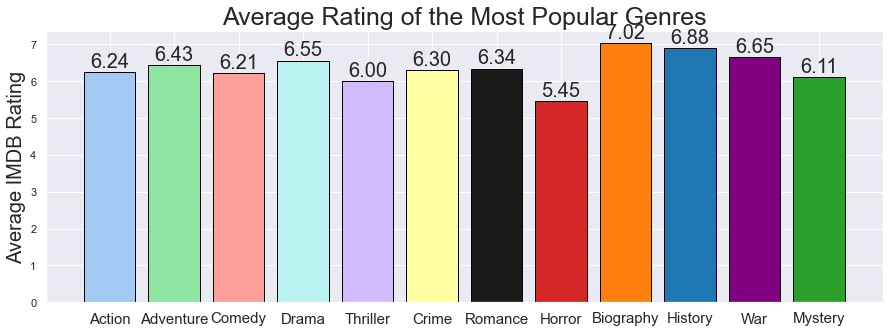

In [18]:
#Creating dataframe for easier use
merged_gratings_df = movies_df.groupby(['genres']).mean().drop(columns=['numvotes','runtime_minutes'])
#Filtering out the most popular genres
merged_gratings_df = merged_gratings_df.filter(
    axis=0,
    items=['Action','Adventure', 'Comedy', 'Drama', 'Thriller','Crime','Romance','Horror','Biography','History','War','Mystery']
)

fig, ax = plt.subplots(figsize=(15,5))
colors = ['b','g','r','c','m','y','k','tab:red','tab:orange','tab:blue','purple','tab:green']

ax.bar(merged_gratings_df.index, merged_gratings_df['averagerating'], color=colors, edgecolor='black')
ax.tick_params(axis='x', labelsize=15)
ax.set_title('Average Rating of the Most Popular Genres', fontsize=25)
ax.set_ylabel('Average IMDB Rating', fontsize=20)
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.02f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', fontsize=20)
    
plt.show()

### Genre Profitability
Horror, Mystery, and Thriller films seem to yield the best return on investment; however, they are among some of the lowest grossing films with Thrillers only just barely making the top 10. 

Thrillers are, however, among the top 5 most popular film genres. Action, Adventure are two popular film types and among the highest total gross but their average ROI isn't as high relative to other genres. This may be because those genres may have larger crews, more special effects, more travel/different set locations, among other factors.

While Horror, on average, is poorly rated, it has one of the highest ROI of almost 800%. Interestingly enough, Horrors don't yield high gross revenues. Their production budget is just so low.

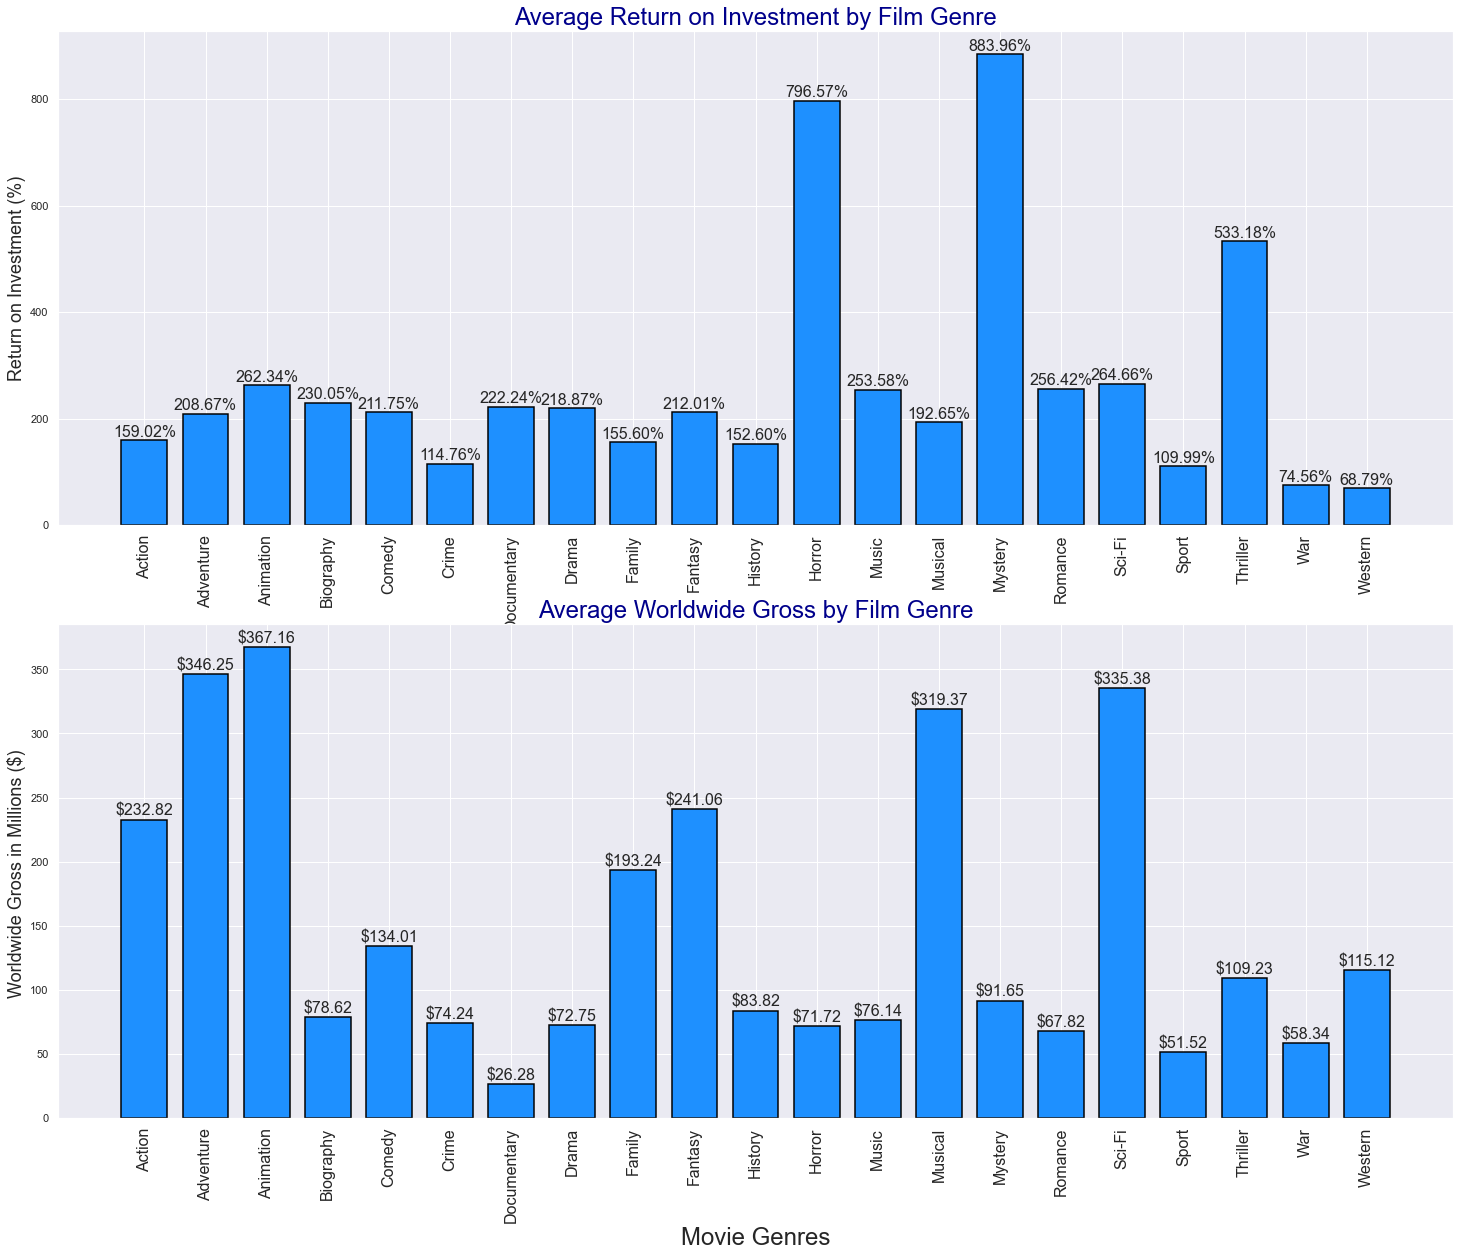

In [19]:
fig, (ax1, ax2)= plt.subplots(nrows=2, ncols=1, figsize=(25,20))
#Return on Investment Bar Chart
ax1.bar(
    movies_df.groupby('genres').roi.mean().index, 
    movies_df.groupby('genres').roi.mean(),
    color = 'dodgerblue',
    edgecolor = 'black',
    linewidth=1.5,
    width = 0.75,
)

ax1.tick_params(axis='x', rotation=90, labelsize=16)
ax1.set_title('Average Return on Investment by Film Genre', fontsize=24, color='darkblue')
ax1.set_ylabel('Return on Investment (%)', fontsize=18)

for rect in ax1.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.02f}%".format(y_value)
    ax1.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', fontsize=16)

#Worldwide Gross Bar Chart    
ax2.bar(
    movies_df.groupby('genres').worldwide_gross.mean().index, 
    movies_df.groupby('genres').worldwide_gross.mean(),
    color = 'dodgerblue',
    edgecolor = 'black',
    linewidth=1.5,
    width = 0.75,
)

ax2.tick_params(axis='x', rotation=90, labelsize=16)
ax2.set_title('Average Worldwide Gross by Film Genre', fontsize=24, color='darkblue')
ax2.set_ylabel('Worldwide Gross in Millions ($) ', fontsize=18)
ax2.set_xlabel('Movie Genres', fontsize=24)

for rect in ax2.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "${:.02f}".format(y_value)
    ax2.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', fontsize=16)    

plt.show()

In [20]:
#Mean and Median Return on Investment and Worldwide Gross on the 5 most popular film genres
movies_df.groupby('genres').roi.agg(['count', 'mean', 'median']).sort_values('count', ascending=False).iloc[:5]

,count,mean,median
genres,,,
Drama,724,218.873794,82.200401
Comedy,510,211.753074,135.257700
Action,442,159.019874,110.878604
Adventure,348,208.670959,164.016187
Thriller,262,533.177501,130.694112


In [21]:
movies_df.groupby('genres').worldwide_gross.agg(['count', 'mean', 'median']).sort_values('count', ascending=False).iloc[:5]

,count,mean,median
genres,,,
Drama,724,72.746940,32.758728
Comedy,510,134.005404,61.536477
Action,442,232.816512,120.522504
Adventure,348,346.251456,227.534361
Thriller,262,109.226800,48.247453


### Runtime Analysis
For the most part, there is little variation between the mean and median runtimes in each genre.

Horror films on average tend to be shorter length; this may be related to their budgets typically being lower. Horror films are also usually rated poorly.

History, Biography, and War are among the longest film genres. I think this is likely because these genres often overlap in films. These genres also have higher average ratings.

There may be a correlation between duration and average rating.

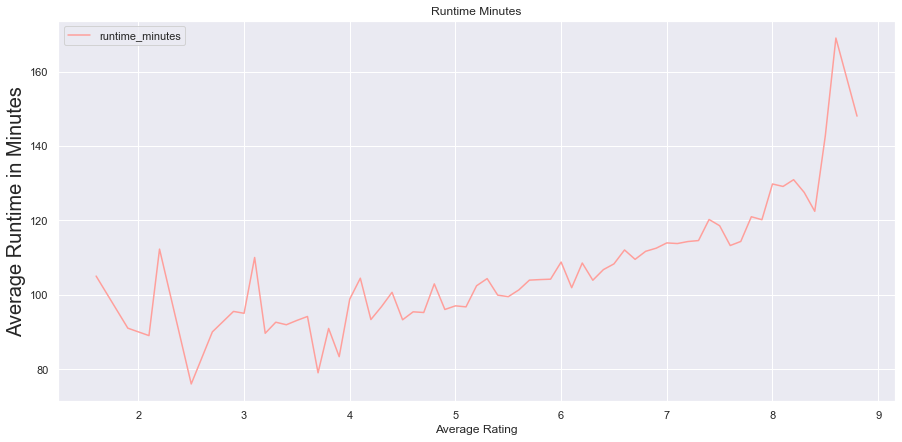

In [22]:
runtime_rating_df.plot(kind='line',figsize=(15,7), color='r')
plt.title('Runtime Minutes')
plt.ylabel('Average Runtime in Minutes', fontsize=20)
plt.xlabel('Average Rating')

plt.show()

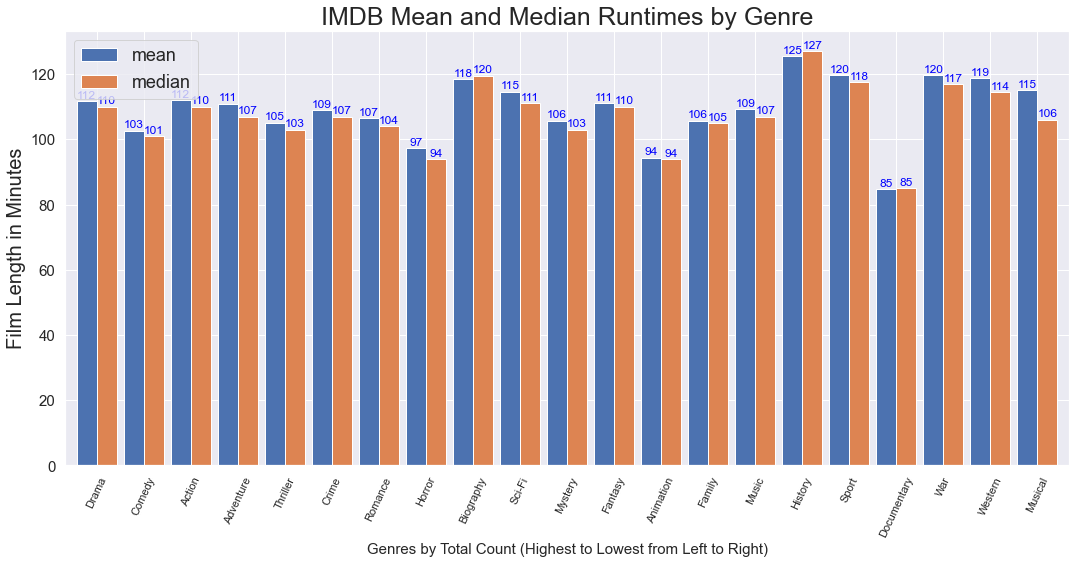

In [23]:
ax = genre_runtime_df.drop(columns = 'count').plot(
    kind = 'bar',
    figsize = (18,8),
    width = .85,
)
plt.title('IMDB Mean and Median Runtimes by Genre', fontsize=25)
plt.xlabel('Genres by Total Count (Highest to Lowest from Left to Right)', fontsize=15)
plt.ylabel('Film Length in Minutes', fontsize=20)
plt.tick_params(axis='x', rotation=65)
plt.tick_params(axis='y', labelsize=15)
plt.legend(prop={'size': 18})

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', color='blue'
    )
plt.show()

### Seasonality of Film Releases
The least amount of movies are released in Spring. Most movies release in December by a fair margin but Winter is second to Fall for in terms of seasonal count. This is because the least amount of films are released in February and January. This could be due to increases in commercial spending during the holiday season.

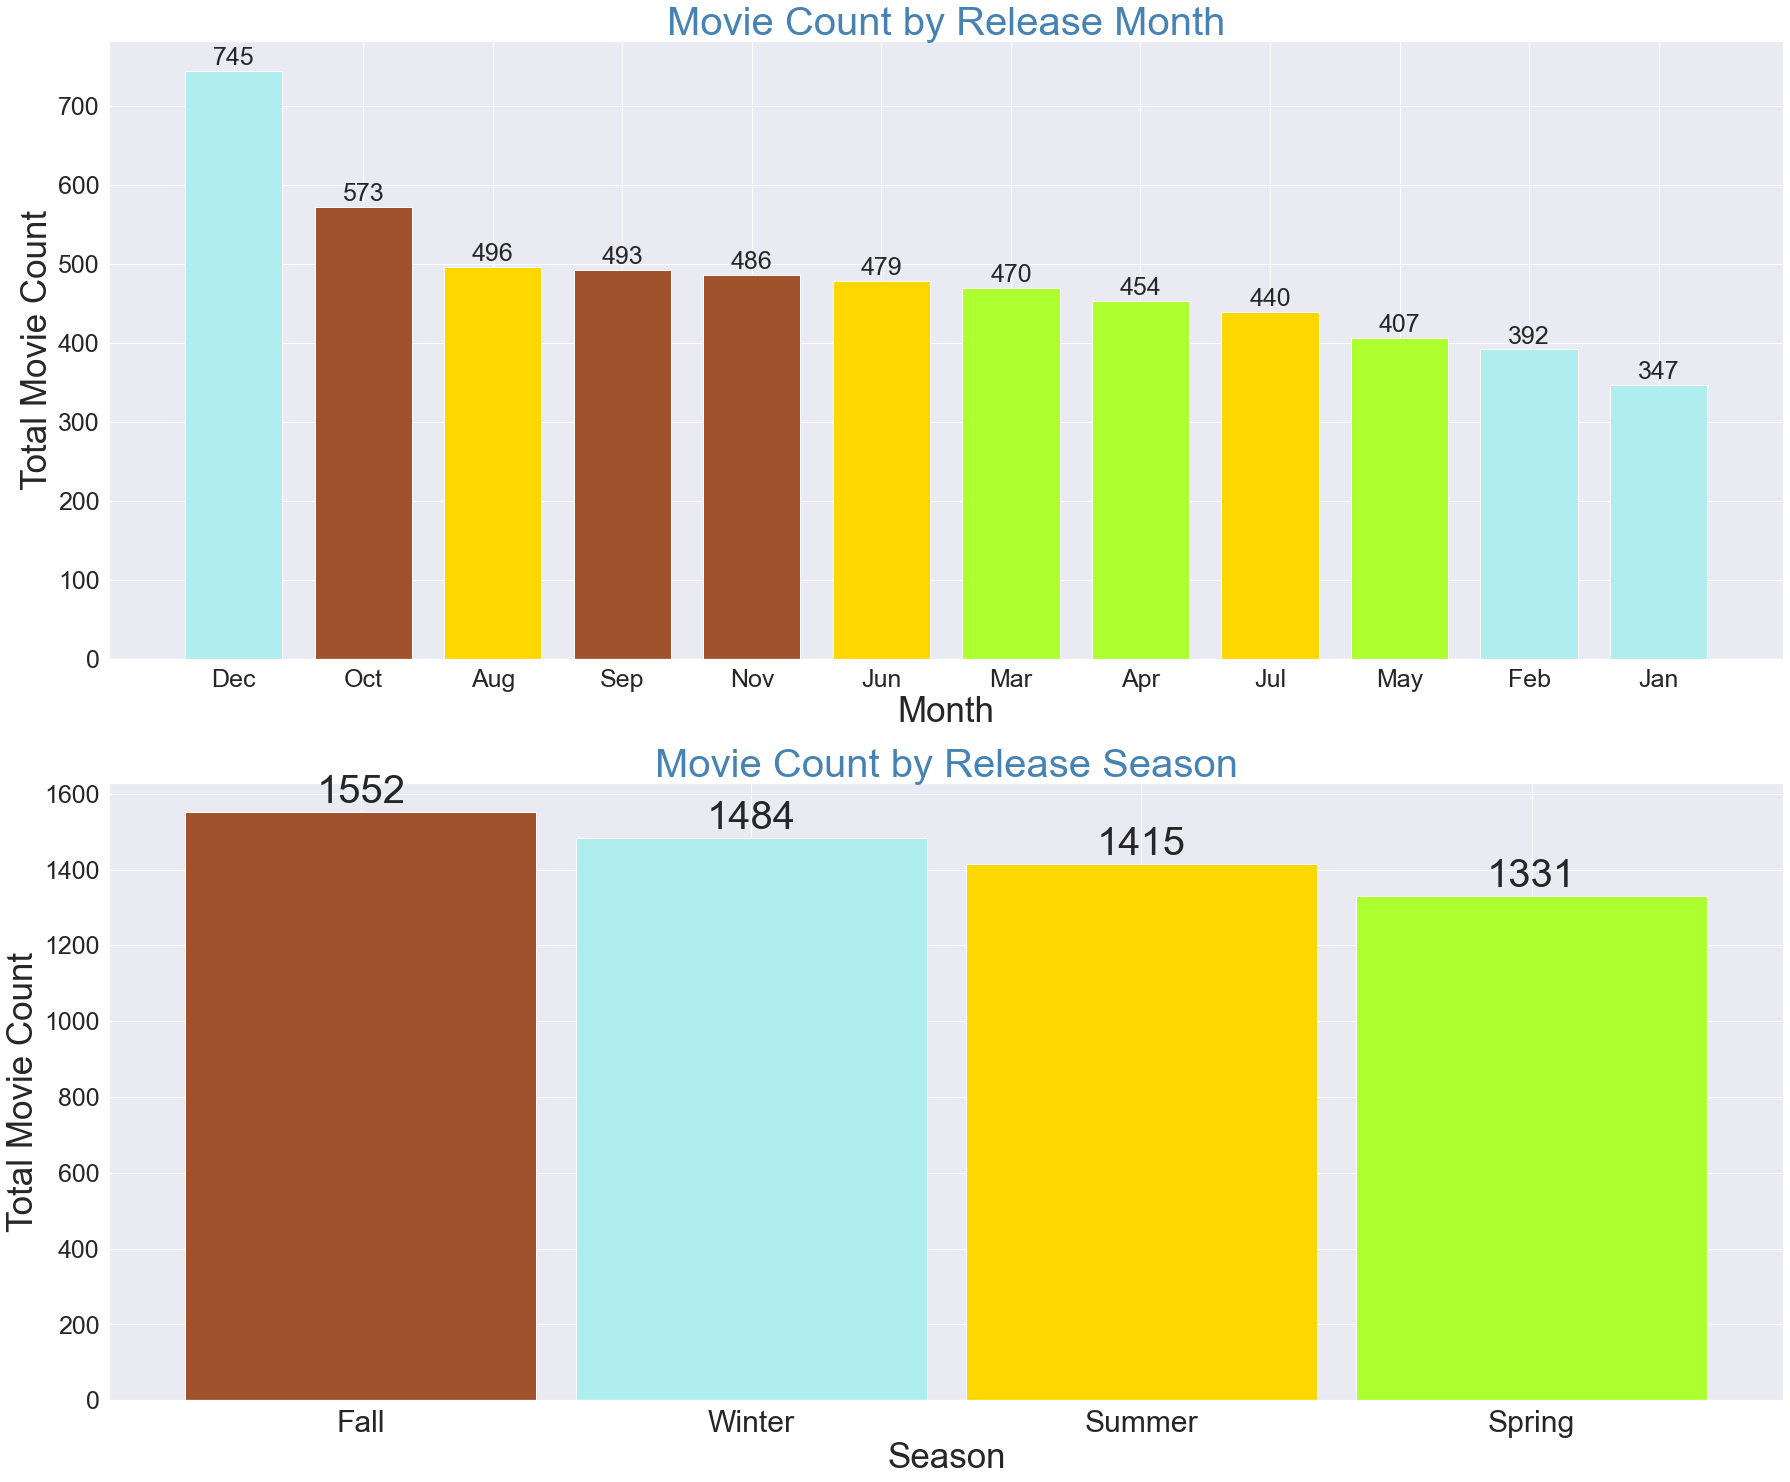

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30,25))
month_counts = tn_df['release_month'].value_counts()
month_colors = [
    'paleturquoise','sienna','gold','sienna','sienna','gold',
    'greenyellow','greenyellow','gold','greenyellow','paleturquoise','paleturquoise'
]

ax1.bar(month_counts.index, month_counts, width=0.75, color=month_colors)
ax1.set_title('Movie Count by Release Month', fontsize=40, color='steelblue')
ax1.set_xlabel('Month', fontsize=35)
ax1.set_ylabel('Total Movie Count', fontsize=35)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
for rect in ax1.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax1.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', fontsize=25
    )
    
season_counts = tn_df['release_season'].value_counts()
season_colors = ['sienna', 'paleturquoise', 'gold', 'greenyellow']                 
ax2.bar(season_counts.index, season_counts, width=0.9, color=season_colors)
ax2.set_title('Movie Count by Release Season', fontsize=40, color='steelblue')
ax2.set_xlabel('Season', fontsize=35)
ax2.set_ylabel('Total Movie Count', fontsize=35)
ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=25)
for rect in ax2.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax2.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', fontsize=40
    )

plt.show()

Although December seems to be the most common time for films to be released, they don’t appear to be too profitable. It may be because there are too many films competing with one another and possibly also an overestimation on business during the holidays. Contrarily, January and February seem to do fairly well on average despite the lower number of films released; this may support my theory on competition.

The Summer seasons seem to do the best from May to July in both average ROI and worldwide gross. Summer is typically when big budget films come out and aptly named “Summer Blockbusters” are released.

There are fairly large gaps between mean and median, this is likely because of those few major box office successes that skew the data. 


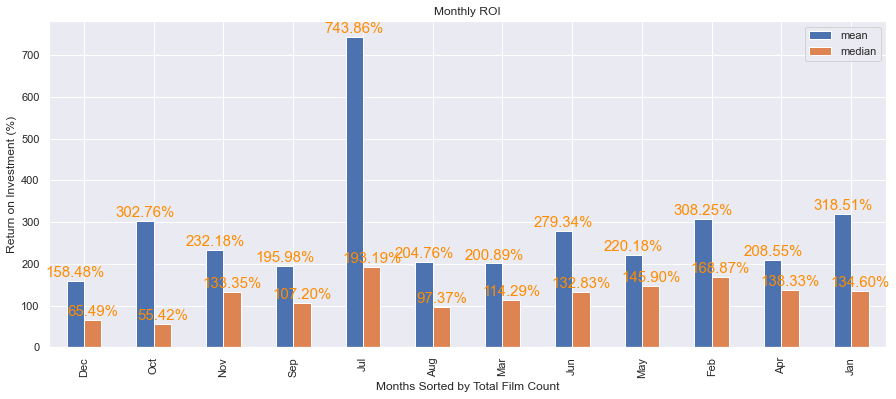

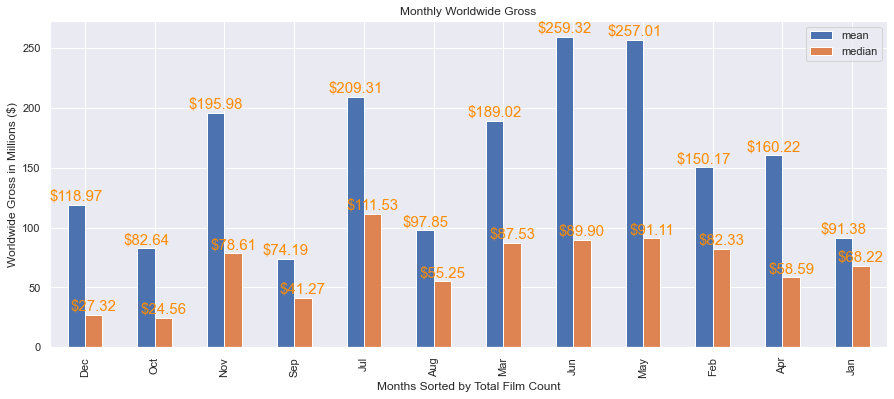

In [25]:
#Plotting ROI by Release Month
ax1 = movies_df.groupby('release_month').roi.agg(['count','mean','median']).sort_values('count', ascending=False).drop(columns='count')
ax1 = ax1.plot(
    kind='bar', figsize=(15,6), title='Monthly ROI'
)
ax1.set_ylabel('Return on Investment (%)')
ax1.set_xlabel('Months Sorted by Total Film Count')
for rect in ax1.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.02f}%".format(y_value)
    ax1.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', color='darkorange', fontsize=15
    )
    
    
#Plotting Worldwide Gross by Release Month
ax2 = movies_df.groupby('release_month').worldwide_gross.agg(['count','mean','median']).sort_values('count', ascending=False).drop(columns='count')
ax2 = ax2.plot(
    kind='bar', figsize=(15,6), title='Monthly Worldwide Gross'
)
ax2.set_ylabel('Worldwide Gross in Millions ($)')
ax2.set_xlabel('Months Sorted by Total Film Count')
for rect in ax2.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "${:.02f}".format(y_value)
    ax2.annotate(
        label, (x_value, y_value), xytext=(0, space), textcoords="offset points", 
        ha='center', va='bottom', color='darkorange', fontsize=15
    )
plt.show()

### Examining Specific Genres in Specific Months
Mystery, Thriller, and Horror are have the best return on investment because of their low production budget. There are more films of these genres released in October, likely ahead of Halloween. There may also be a slight positive trend in percentage of Horror films made.

In [26]:
#Creating a dataframe to examine the percentages of each genre released per month
month_genre_df = movies_df[['release_month','genres']].pivot_table(
    index=['release_month'], columns=['genres'], aggfunc=len, fill_value=0
).T
month_genre_df = (100 * month_genre_df/month_genre_df.sum()).round(2)
month_horror_df = month_genre_df.query("genres == ['Horror','Mystery','Thriller']")

#Creating a dataframe to examine percentages of each genre released per year
horror_yr = movies_df[['release_year','genres']].pivot_table(
    index=['release_year'], columns=['genres'], aggfunc=len, fill_value=0
).T
horror_yr = (100 * horror_yr/horror_yr.sum()).round(2)
horror_yr = horror_yr.query("genres == ['Horror','Mystery','Thriller']")
horror_yr = horror_yr.T

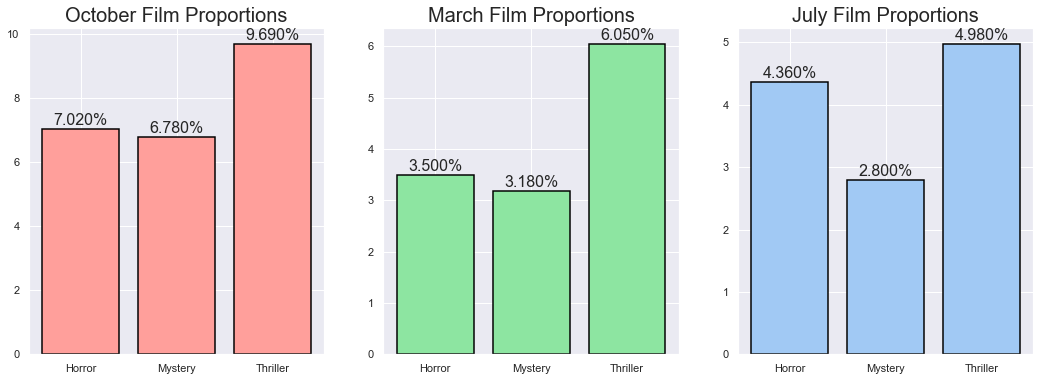

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
#Plotting for films released in October
ax1.bar(
    month_horror_df.index, 
    month_horror_df['Oct'],
    color='r',
    edgecolor='black',
    width=0.8,
    linewidth=1.5
)
ax1.set_title('October Film Proportions', fontsize=20)
for rect in ax1.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.03f}%".format(y_value)
    ax1.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', fontsize=16)

#I chose two random months to compare to October and chose March and July
ax2.bar(
    month_horror_df.index, 
    month_horror_df['Mar'],
    color='g',
    edgecolor='black',
    width=0.8,
    linewidth=1.5
)
ax2.set_title('March Film Proportions',fontsize=20)
for rect in ax2.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.03f}%".format(y_value)
    ax2.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', fontsize=16)
    
ax3.bar(
    month_horror_df.index, 
    month_horror_df['Jul'],
    color='b',
    edgecolor='black',
    width=0.8,
    linewidth=1.5
)
ax3.set_title('July Film Proportions',fontsize=20)
for rect in ax3.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.03f}%".format(y_value)
    ax3.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom', fontsize=16)
    
plt.show()

## Concluding Thoughts
Through this analysis, I have some recommendations regarding genre selection, release date, and film duration for Microsoft's strategy:

#### Financial Success:
* The summer season is the best time to release a big budget blockbuster Adventure/Action film as those films yield some of the largest gross revenues. However, competing in this space would require a large amount of risk because of the larger production budgets.
* Scary movies (Horror, Thriller, Mystery) are typically low budget so the gross revenues aren't as high as other genres. They do have high returns on investments because of the lower budgets and risk. These films are most commonly released during October and around Fall/Halloween.
* Although the most films are released in December, that doesn't yield great results. I believe this to be due to increased competition and that may be why films released in a January, the slowest month, tend to be more commercially successful.

#### Critical Success:
* Longer films appear to translate into more positive reviews. Historical/Biographical films have the highest average ratings and also the longest average runtime, while Horror films have the lowest average ratings and also the shortest average runtime.
* Critical success doesn't necessarily translate to financial success. Historical/Biographical films perform poorly in both ROI and worldwide gross, while Horror films perform extremely well in ROI.

A high risk-high reward route would be competing with other popular high budget Action films in the Summer. 

A safer option would be putting out a shorter and cheaper scary movie. Although it may not be well-received, there's a good chance it's profitable and you make back your money and then some.

Regardless of genre or budget, I don't recommend releasing a film during the Holiday season. I think there is too much risk and little pay off.
***

### Next Steps
One problem that I encountered with the data was merging the datasets. There were a good amount of films that overlapped properly, but there was also a very large amount of films that didn't so my representation may not be sufficient enough. 
* The IMDB data only had film data from 2010 to 2018 and part of 2019. 
* The Numbers data seemed to only have data on larger releases, particularly Western films

To improve my analysis, I would like to get more data. Also, my method of splitting films into a separate entry for each genre may have been flawed and created some issues like skewing data.

***
The IMDB data can be extracted further and I could apply my same methods in examining actors, directors, writers, and other cast/crew's relationship with genres, ratings, revenues. 

For example, certain actors may be more common in specific genres. This could be potentially useful with casting a successful lead.

### Thank You!